# Vision por Computadora II - CEIA

## Trabajo Final

#### Autor: Juan Ignacio Ribet

En el siguiente trabajo se busca clasificar imágenes de diferentes posturas de yoga utilizando
redes neuronales

- Objetivo: estimar posturas por video en tiempo real
- Problema: clasificación multiclase
- Cantidad de clases: 4
- Nombre de las clases: 'downdog', 'goddess', 'tree', 'warrior'
- Total de imágenes del dataset: 1102
- División Train-Test: 80-20%
- Arquitecturas de modelos: ResNet18, ResNet50, VGG19
- Visualización GradCAM (mejor modelo)

Además se utiliza el framework de MediaPipe para realizar una clasificación obteniendo los puntos
característicos de la postura

In [19]:
import random
import os
import platform
import sys
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [20]:
if 'google.colab' in sys.modules:
    !pip install torchmetrics
    !pip install --upgrade --no-cache-dir gdown
    import gdown

In [21]:
import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter

In [22]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

### Descarga del Dataset

In [23]:
# Descargar la carpeta de dataset

if os.access('./DATASET', os.F_OK) is False:
    if os.access('DATASET', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://github.com/Juaniribet/Vision_Computadora_II_CEIA/main/DATASET.zip -o DATASET.zip
        else:
            !wget DATASET.zip https://github.com/Juaniribet/Vision_Computadora_II_CEIA/raw/main/DATASET.zip
    !unzip -q DATASET.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


### Visualización de los datos

Defino variables y vizualizamos cada clase

In [24]:
if 'google.colab' in sys.modules:
  train_folder = '/content/DATASET/TRAIN'
  test_folder = '/content/DATASET/TEST'
  valid_folder = '/content/DATASET/VALID'
  dataset_folder = '/content/DATASET'
else:
  train_folder = 'DATASET/TRAIN'
  test_folder = 'DATASET/TEST'
  valid_folder = 'DATASET/VALID'
  dataset_folder = 'DATASET'

CLASES = []
for class_name in os.listdir(train_folder):
  CLASES.append(class_name)

CANTIDAD_CLASES = len(CLASES)
ANCHO_IMAGENES = 224
ALTO_IMAGENES = 224

print(f'CLASES: {CLASES}')
print(f'CANTIDAD_CLASES: {CANTIDAD_CLASES}')

CLASES: ['downdog', 'goddess', 'tree', 'warrior']
CANTIDAD_CLASES: 4


Device: cuda


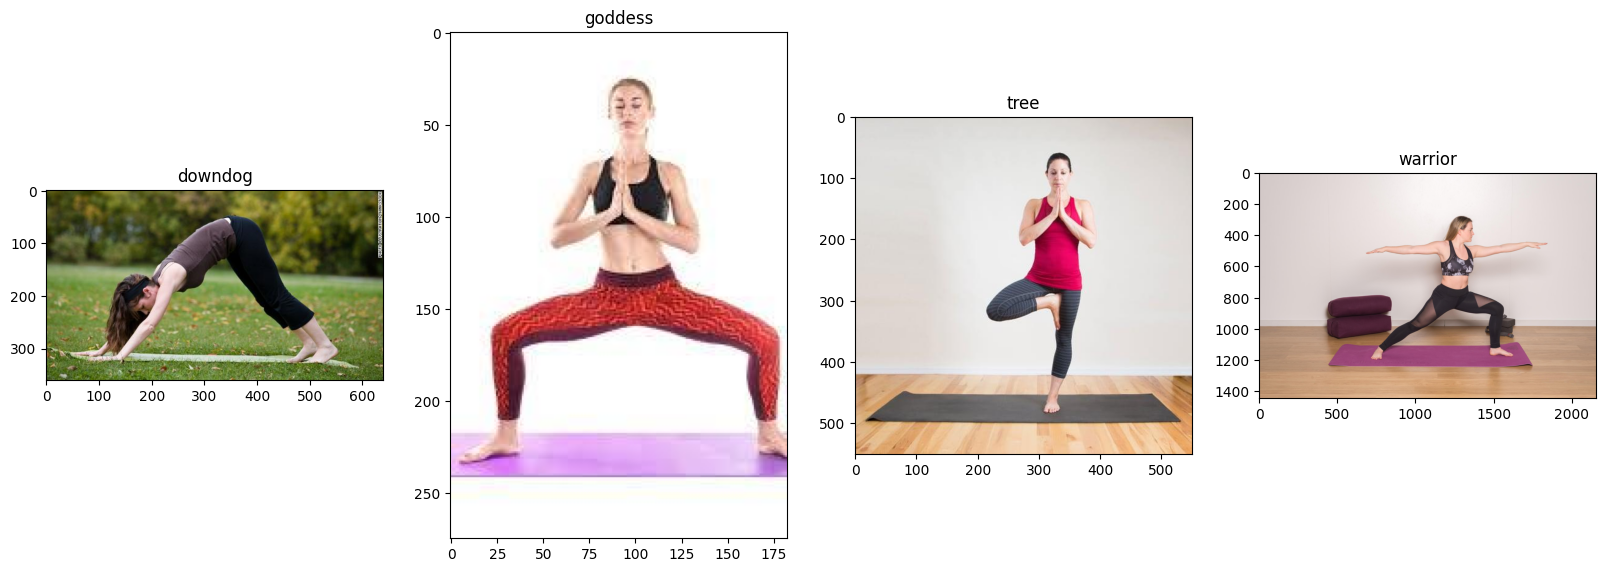

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fig, axs = plt.subplots(1, CANTIDAD_CLASES, figsize=(20, 20))

for id, class_folder in enumerate(sorted(os.listdir(train_folder))):

    image_name = random.choice(os.listdir(os.path.join(train_folder, class_folder)))
    image = mpimg.imread(os.path.join(train_folder, class_folder, image_name))

    axs[id].imshow(image)
    axs[id].set_title(class_folder)

print(f'Device: {device}')

### Definición de la función de entrenamiento

In [26]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [27]:
aug_data_transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                        torchvision.transforms.RandomHorizontalFlip(0.5),
                        torchvision.transforms.RandomResizedCrop(size=(ANCHO_IMAGENES,
                                                                       ALTO_IMAGENES),
                                                                 scale=(0.5, 1.0)),
                        #torchvision.transforms.ColorJitter(saturation=0.1, hue=0.1),
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                         std=(0.229, 0.224, 0.225))
                      ])

data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
                    torchvision.transforms.ToTensor()
                  ])

train_set = torchvision.datasets.ImageFolder(root=train_folder
                                                    , transform=data_transforms)
test_set = torchvision.datasets.ImageFolder(root=test_folder
                                                    , transform=data_transforms)


train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

In [28]:
idx_to_name = {}
for cls, i in enumerate(train_loader.dataset.classes):
  idx_to_name[cls] = i

idx_to_name

{0: 'downdog', 1: 'goddess', 2: 'tree', 3: 'warrior'}

In [29]:
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float().to(device)
    image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()
])

# Modelo ResNet 18

El modelo [resnet18](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) provisto por torchvision cuenta con un set de parametros preentrenados con ImageNet, los cuales consiguen metricas similares a las del paper original. Dada la arquitectura del modelo, la cual cuenta con una capa de [Adaptative Average Pooling](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html?highlight=adaptiveavgpool2d#torch.nn.AdaptiveAvgPool2d) y solo una capa densa al final, puede tomar entradas de dimensiones muy pequeñas.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights
torch.cuda.empty_cache()
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [ ]:
resnet18_model = resnet18(weights=weights)
#resnet18_model = resnet18()

resnet18_model.to(device)

torchsummary.summary(resnet18_model, input_size=(3, 224, 224))
resnet18_model.modules

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
for param in resnet18_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features,
                                    out_features=CANTIDAD_CLASES)

Epoch: 1/150 - Train loss 1.543021 - Train Accuracy 0.248884 - Valid Loss 1.518062 - Valid Accuracy 0.251786
Epoch: 2/150 - Train loss 1.513099 - Train Accuracy 0.258929 - Valid Loss 1.538381 - Valid Accuracy 0.229464
Epoch: 3/150 - Train loss 1.483103 - Train Accuracy 0.267857 - Valid Loss 1.527248 - Valid Accuracy 0.202679
Epoch: 4/150 - Train loss 1.480151 - Train Accuracy 0.258929 - Valid Loss 1.511987 - Valid Accuracy 0.208036
Epoch: 5/150 - Train loss 1.466049 - Train Accuracy 0.257812 - Valid Loss 1.503487 - Valid Accuracy 0.210714
Epoch: 6/150 - Train loss 1.462591 - Train Accuracy 0.258929 - Valid Loss 1.488042 - Valid Accuracy 0.227083
Epoch: 7/150 - Train loss 1.441108 - Train Accuracy 0.272321 - Valid Loss 1.477507 - Valid Accuracy 0.244345
Epoch: 8/150 - Train loss 1.440357 - Train Accuracy 0.270089 - Valid Loss 1.471615 - Valid Accuracy 0.247619
Epoch: 9/150 - Train loss 1.427549 - Train Accuracy 0.266741 - Valid Loss 1.462370 - Valid Accuracy 0.237500
Epoch: 10/150 - Tra

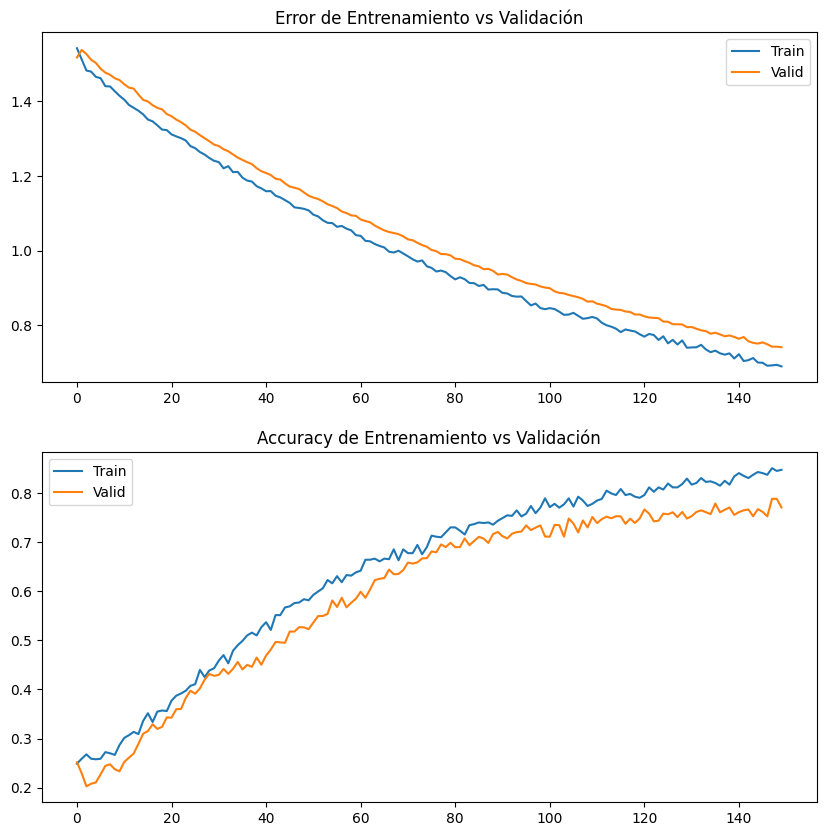

In [ ]:
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_loader,
        "valid": test_loader,
        "image_width": ANCHO_IMAGENES,
        "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="Resnet18/train"),
          "valid": SummaryWriter(log_dir="Resnet18/valid")}

history = train(resnet18_model.to("cpu"),
                optimizer,
                loss,
                metric,
                data,
                150,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [ ]:
# # Guardar modelo
# torch.save(resnet18_model.state_dict(), '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/resnet18_model_yoga.pt')
# torch.save(resnet18_model, '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/resnet18_model_yoga_tl.pt')
# torch.save(resnet18_model.state_dict(), '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/resnet18_model_yoga_aug-tl.pt')

In [ ]:
# Cargar modelo guardado
torch.cuda.empty_cache()
resnet18_model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features,
                                    out_features=CANTIDAD_CLASES)
resnet18_model.load_state_dict(torch.load('models/resnet18_model_yoga_tl.pt',
                                           map_location=device))

<All keys matched successfully>

### Verificación del modelo en las 4 imagenes de validación

In [ ]:
resnet18_model.eval().to(device)

path = valid_folder

for image in os.listdir(path):
  pred = np.argmax(
    resnet18_model(image_loader(data_transforms, path + '/' + image))
    .to('cpu').detach().numpy())

  class_name = str(image).replace('.jpg', '')

  print(f' File name: {image} - Class: {class_name} - Prediction: {idx_to_name[pred]}')

 File name: downdog.jpg - Class: downdog - Prediction: downdog
 File name: goddess.jpg - Class: goddess - Prediction: goddess
 File name: tree.jpg - Class: tree - Prediction: tree
 File name: warrior.jpg - Class: warrior - Prediction: warrior


### Inferencias en el set de test

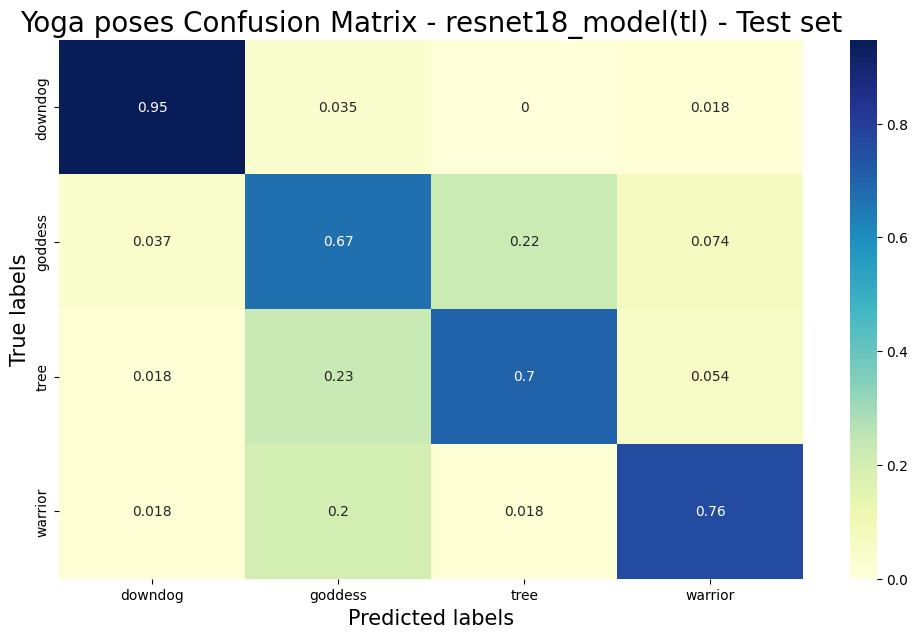

Accuracy Test set : 77.03%


In [ ]:
path = test_folder

y_test_resnet18 = []
y_test_hat_resnet18 = []

for class_name in os.listdir(path):
  for image in os.listdir(path + '/' + class_name):
    pred = np.argmax(
      resnet18_model(
        image_loader(data_transforms, path + '/' + class_name + '/' + image)).to('cpu')
        .detach().numpy())

    y_test_resnet18.append(class_name)

    y_test_hat_resnet18.append(idx_to_name[pred])

cf_matrix = confusion_matrix(y_test_resnet18, y_test_hat_resnet18)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - resnet18_model(tl) - Test set', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy Test set : {accuracy_score(y_test_resnet18, y_test_hat_resnet18):.2%}')

### Inferencias en el set de train

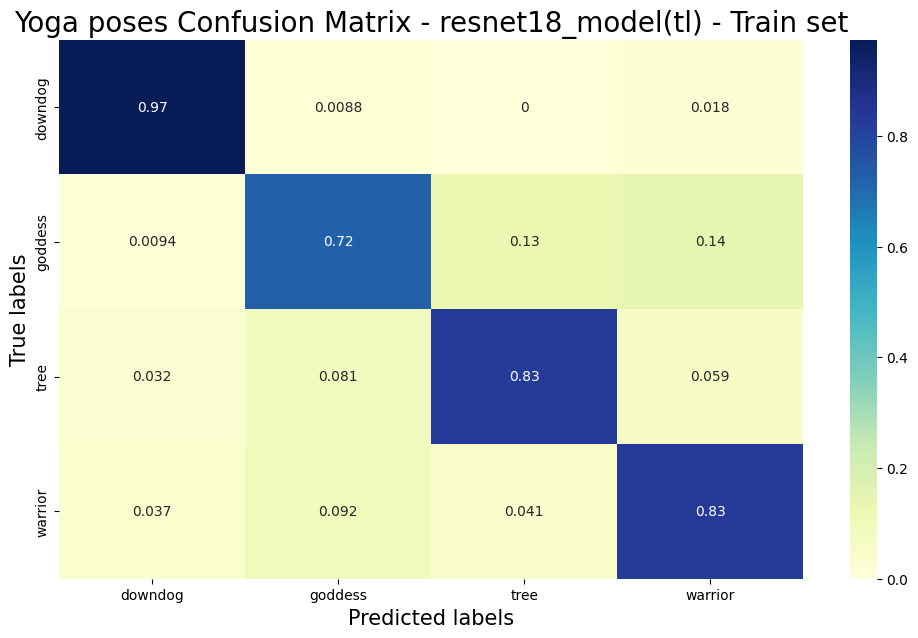

Accuracy Train set : 84.09%


In [ ]:
path = train_folder

y_train_resnet18 = []
y_train_hat_resnet18 = []

for class_name in os.listdir(path):
  for image in os.listdir(path + '/' + class_name):
    pred = np.argmax(
      resnet18_model(
        image_loader(data_transforms, path + '/' + class_name + '/' + image))
        .to('cpu').detach().numpy())

    y_train_resnet18.append(class_name)

    y_train_hat_resnet18.append(idx_to_name[pred])

cf_matrix = confusion_matrix(y_train_resnet18, y_train_hat_resnet18)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - resnet18_model(tl) - Train set', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy Train set : {accuracy_score(y_train_resnet18, y_train_hat_resnet18):.2%}')

### Inferencias del dataset completo

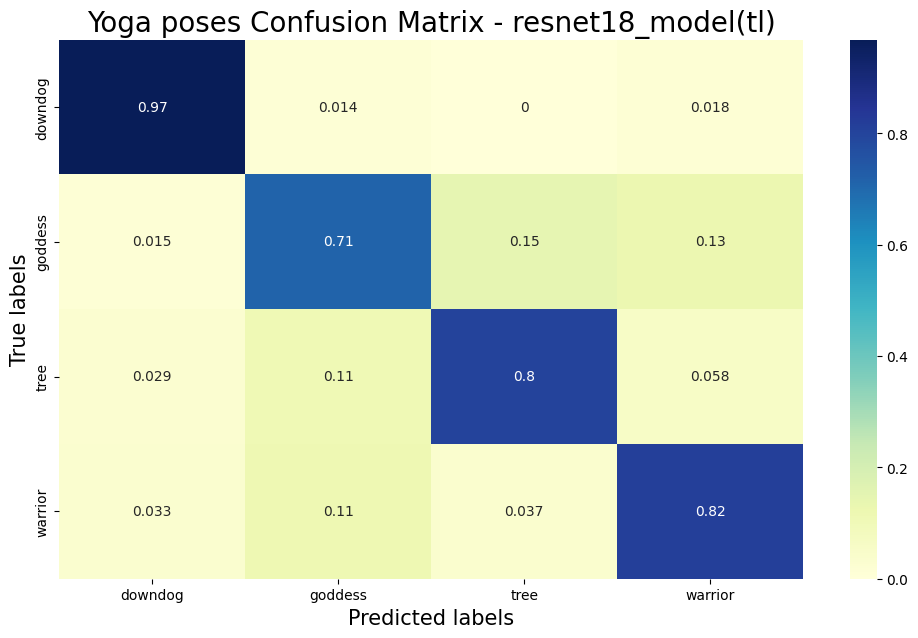

Accuracy all : 82.67%


In [ ]:
path = dataset_folder

y_resnet18 = []
y_hat_resnet18 = []
file_name = []

for folders in ['TRAIN', 'TEST']:
  for class_name in os.listdir(path + '/' + folders):
    for image in os.listdir(path + '/' + folders + '/' + class_name):
      pred = np.argmax(
        resnet18_model(
          image_loader(data_transforms, path + '/' + folders + '/' + class_name + '/' + image))
          .to('cpu').detach().numpy())

      y_resnet18.append(class_name)

      y_hat_resnet18.append(idx_to_name[pred])

      file_name.append(str(class_name) + str(image))

cf_matrix = confusion_matrix(y_resnet18, y_hat_resnet18)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - resnet18_model(tl)', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy all : {accuracy_score(y_resnet18, y_hat_resnet18):.2%}')

# Modelo Resnet50

In [37]:
from torchvision.models import resnet50, ResNet50_Weights
torch.cuda.empty_cache()
weights = ResNet50_Weights.IMAGENET1K_V2
transforms = weights.transforms()

In [38]:
resnet50_model = resnet50(weights=weights)
#resnet50_model = resnet50()

resnet50_model.to(device)

torchsummary.summary(resnet50_model, input_size=(3, 224, 224))
resnet50_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256,

In [39]:
for param in resnet50_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

Epoch: 1/100 - Train loss 1.388631 - Train Accuracy 0.264509 - Valid Loss 1.379560 - Valid Accuracy 0.276488
Epoch: 2/100 - Train loss 1.381338 - Train Accuracy 0.301339 - Valid Loss 1.379197 - Valid Accuracy 0.311310
Epoch: 3/100 - Train loss 1.375614 - Train Accuracy 0.291295 - Valid Loss 1.373563 - Valid Accuracy 0.315179
Epoch: 4/100 - Train loss 1.369173 - Train Accuracy 0.324777 - Valid Loss 1.365140 - Valid Accuracy 0.341964
Epoch: 5/100 - Train loss 1.359596 - Train Accuracy 0.351562 - Valid Loss 1.362708 - Valid Accuracy 0.391667
Epoch: 6/100 - Train loss 1.355255 - Train Accuracy 0.362723 - Valid Loss 1.348828 - Valid Accuracy 0.437202
Epoch: 7/100 - Train loss 1.346849 - Train Accuracy 0.387277 - Valid Loss 1.346900 - Valid Accuracy 0.387202
Epoch: 8/100 - Train loss 1.341035 - Train Accuracy 0.416295 - Valid Loss 1.336776 - Valid Accuracy 0.469345
Epoch: 9/100 - Train loss 1.334749 - Train Accuracy 0.456473 - Valid Loss 1.341239 - Valid Accuracy 0.458333
Epoch: 10/100 - Tra

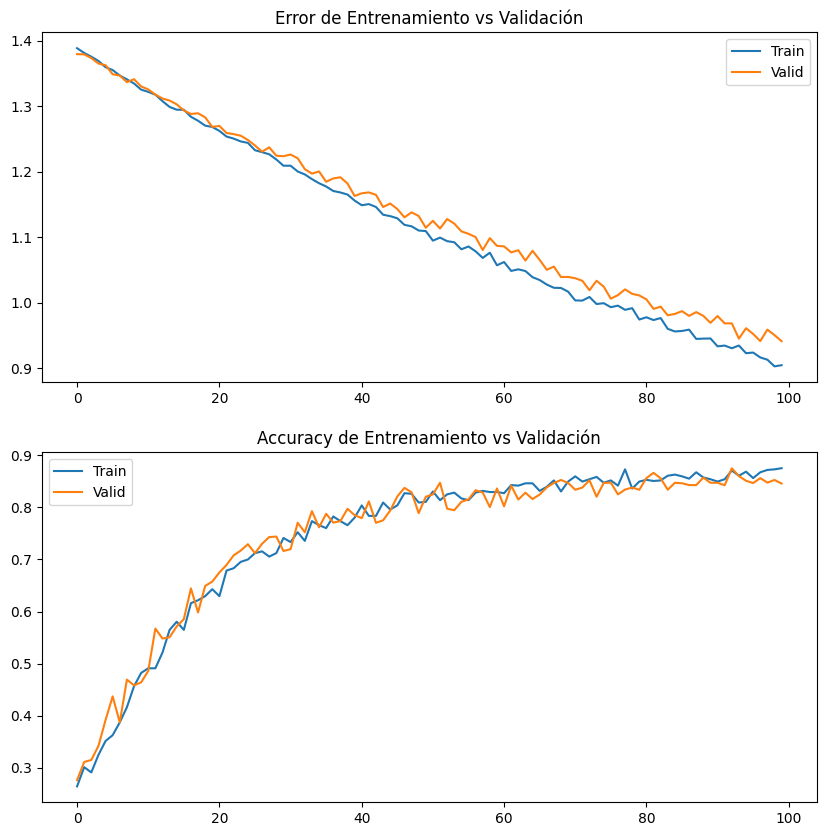

In [40]:
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_loader,
        "valid": test_loader,
        "image_width": ANCHO_IMAGENES,
        "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="ResNet50/train"),
          "valid": SummaryWriter(log_dir="ResNet50/valid")}

history = train(resnet50_model.to("cpu"),
                optimizer,
                loss,
                metric,
                data,
                100,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [41]:
# # Guardar modelo
# torch.save(resnet50_model.state_dict(), '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/resnet50_model_yoga.pt')
# torch.save(resnet50_model.state_dict(), '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/resnet50_model_yoga_tl.pt')
# torch.save(resnet50_model.state_dict(), '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/resnet50_model_yoga_tl-aug.pt')

In [ ]:
# Cargar modelo guardado
torch.cuda.empty_cache()
resnet50_model = torchvision.models.resnet50(
    weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)
last_layer_in_features = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(in_features=last_layer_in_features,
                                    out_features=CANTIDAD_CLASES)
resnet50_model.load_state_dict(torch.load('models/resnet50_model_yoga_tl-aug.pt',
                                           map_location=device))

### Verificación del modelo en las 4 imagenes de validación

In [42]:
resnet50_model.eval().to(device)

path = valid_folder

for image in os.listdir(path):
  pred = np.argmax(
    resnet50_model(image_loader(data_transforms, path + '/' + image))
    .to('cpu').detach().numpy())

  class_name = str(image).replace('.jpg', '')

  print(f' File name: {image} - Class: {class_name} - Prediction: {idx_to_name[pred]}')

 File name: warrior.jpg - Class: warrior - Prediction: warrior
 File name: tree.jpg - Class: tree - Prediction: goddess
 File name: downdog.jpg - Class: downdog - Prediction: downdog
 File name: goddess.jpg - Class: goddess - Prediction: warrior


### Inferencias en el set de test

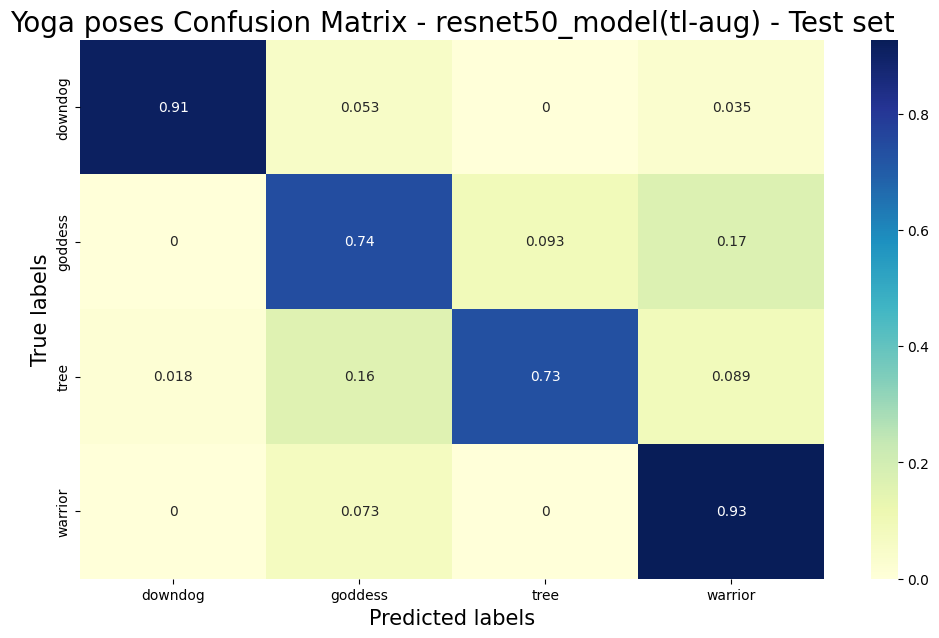

Accuracy Test set : 82.88%


In [43]:
path = test_folder

y_test_resnet50 = []
y_test_hat_resnet50 = []

for class_name in os.listdir(path):
  for image in os.listdir(path + '/' + class_name):
    pred = np.argmax(
      resnet50_model(
        image_loader(data_transforms, path + '/' + class_name + '/' + image)).to('cpu')
        .detach().numpy())

    y_test_resnet50.append(class_name)

    y_test_hat_resnet50.append(idx_to_name[pred])

cf_matrix = confusion_matrix(y_test_resnet50, y_test_hat_resnet50)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - resnet50_model(tl-aug) - Test set', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy Test set : {accuracy_score(y_test_resnet50, y_test_hat_resnet50):.2%}')

### Inferencias en el set de train

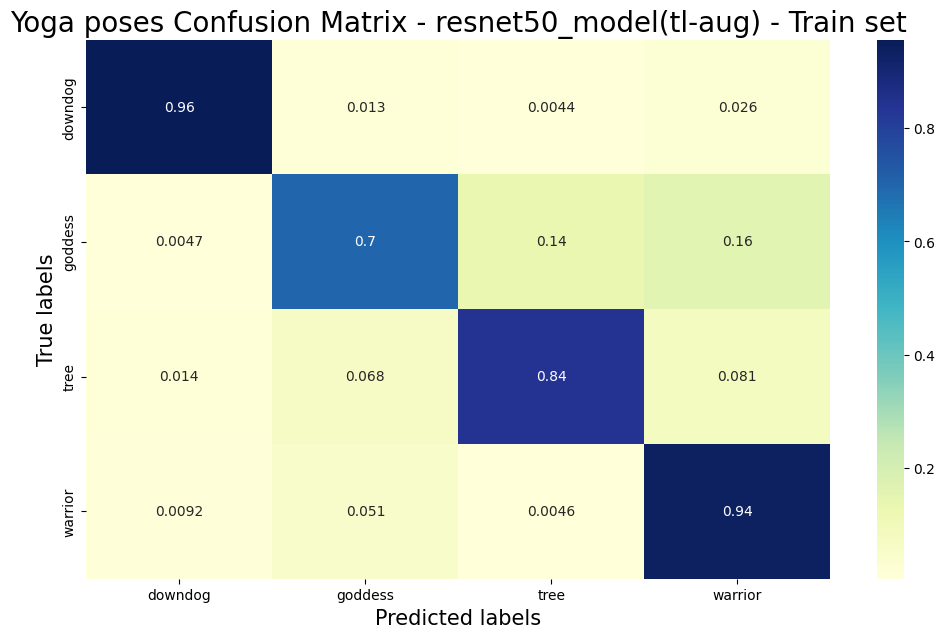

Accuracy Train set : 85.91%


In [44]:
path = train_folder

y_train_resnet50 = []
y_train_hat_resnet50 = []

for class_name in os.listdir(path):
  for image in os.listdir(path + '/' + class_name):
    pred = np.argmax(
      resnet50_model(
        image_loader(data_transforms, path + '/' + class_name + '/' + image))
        .to('cpu').detach().numpy())

    y_train_resnet50.append(class_name)

    y_train_hat_resnet50.append(idx_to_name[pred])

cf_matrix = confusion_matrix(y_train_resnet50, y_train_hat_resnet50)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - resnet50_model(tl-aug) - Train set', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy Train set : {accuracy_score(y_train_resnet50, y_train_hat_resnet50):.2%}')

### Inferencias del dataset completo

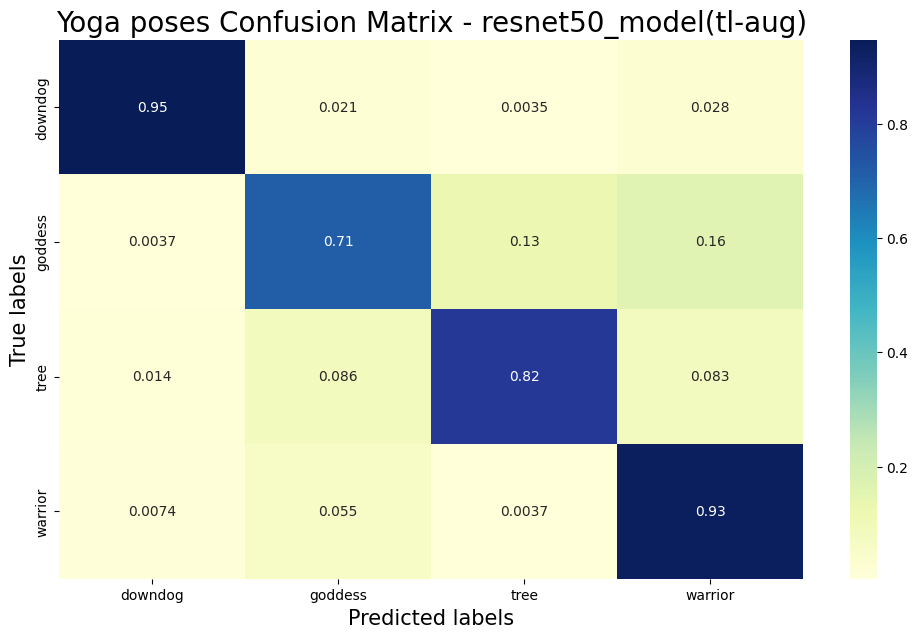

Accuracy all : 85.30%


In [45]:
path = dataset_folder

y_resnet50 = []
y_hat_resnet50 = []
file_name = []

for folders in ['TRAIN', 'TEST']:
  for class_name in os.listdir(path + '/' + folders):
    for image in os.listdir(path + '/' + folders + '/' + class_name):
      pred = np.argmax(
          resnet50_model(image_loader
                      (data_transforms, path + '/' + folders + '/' + class_name + '/' + image))
                      .to('cpu').detach().numpy())

      y_resnet50.append(class_name)

      y_hat_resnet50.append(idx_to_name[pred])

      file_name.append(str(class_name) + str(image))

cf_matrix = confusion_matrix(y_resnet50, y_hat_resnet50)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - resnet50_model(tl-aug)', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy all : {accuracy_score(y_resnet50, y_hat_resnet50):.2%}')

# Modelo VGG19

La arquitectura de VGG19 tiene los pesos entrenados con el dataset ImageNet

In [47]:
from torchvision.models.vgg import VGG19_Weights
torch.cuda.empty_cache()
weights = VGG19_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [48]:
#vgg19_model = torchvision.models.vgg19(weights=weights)
vgg19_model = torchvision.models.vgg19()

vgg19_model.to(device)

torchsummary.summary(vgg19_model, input_size=(3, 224, 224))
vgg19_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

In [49]:
for param in vgg19_model.parameters():
    param.requires_grad = True

In [50]:
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=CANTIDAD_CLASES)

Epoch: 1/100 - Train loss 1.392633 - Train Accuracy 0.227679 - Valid Loss 1.386050 - Valid Accuracy 0.271131
Epoch: 2/100 - Train loss 1.387293 - Train Accuracy 0.246652 - Valid Loss 1.386192 - Valid Accuracy 0.257143
Epoch: 3/100 - Train loss 1.386346 - Train Accuracy 0.260045 - Valid Loss 1.386043 - Valid Accuracy 0.256250
Epoch: 4/100 - Train loss 1.338452 - Train Accuracy 0.347098 - Valid Loss 1.218854 - Valid Accuracy 0.453869
Epoch: 5/100 - Train loss 0.871610 - Train Accuracy 0.669643 - Valid Loss 0.588252 - Valid Accuracy 0.751488
Epoch: 6/100 - Train loss 0.540564 - Train Accuracy 0.784598 - Valid Loss 0.424981 - Valid Accuracy 0.860119
Epoch: 7/100 - Train loss 0.369490 - Train Accuracy 0.860491 - Valid Loss 0.382346 - Valid Accuracy 0.877679
Epoch: 8/100 - Train loss 0.301039 - Train Accuracy 0.900670 - Valid Loss 0.371198 - Valid Accuracy 0.891071
Epoch: 9/100 - Train loss 0.203068 - Train Accuracy 0.930804 - Valid Loss 0.357919 - Valid Accuracy 0.863988
Epoch: 10/100 - Tra

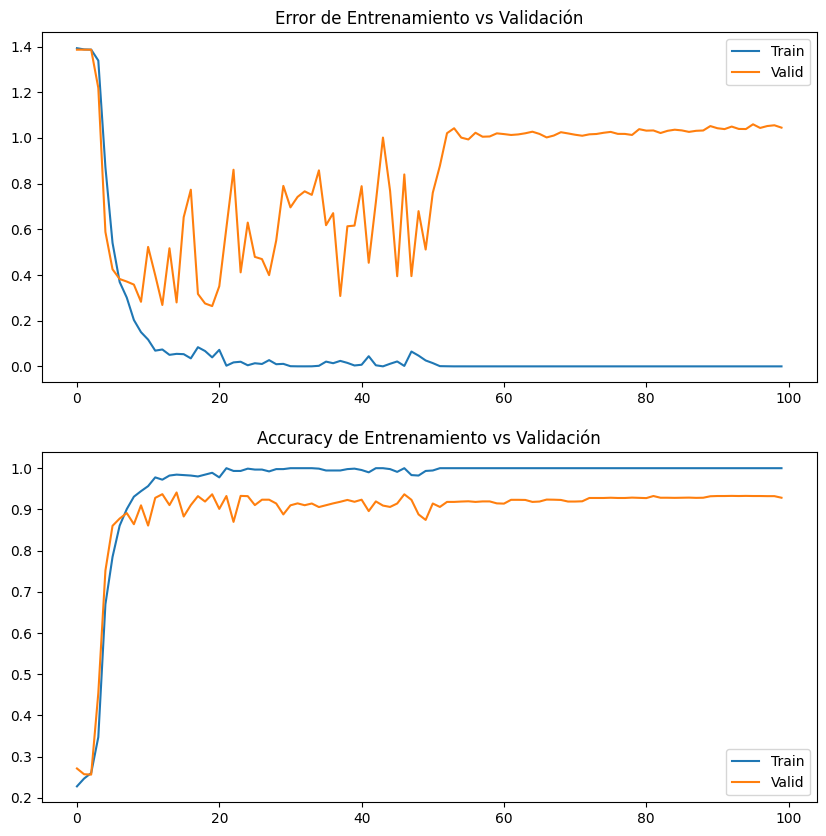

In [51]:
optimizer = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=CANTIDAD_CLASES)
data = {"train": train_loader,
        "valid": test_loader,
        "image_width": ANCHO_IMAGENES,
        "image_height": ALTO_IMAGENES}
writer = {"train": SummaryWriter(log_dir="vgg19/train"),
          "valid": SummaryWriter(log_dir="vgg19/valid")}

history = train(vgg19_model.to("cpu"),
                optimizer,
                loss,
                metric,
                data,
                100,
                writer)

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [ ]:
# # Guardar modelo
# torch.save(vgg19_model.state_dict(), '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/vgg19_model_yoga.pt')
# torch.save(vgg19_model.state_dict(), '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/vgg19_model_yoga_aug.pt')
# torch.save(vgg19_model.state_dict(), '/content/drive/MyDrive/Especializacion_IA/Vision Computadora II/vgg19_model_yoga_tl-aug.pt')

In [30]:
# Cargar modelo guardado
torch.cuda.empty_cache()
vgg19_model = torchvision.models.vgg19()
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features,
                                              out_features=CANTIDAD_CLASES)
vgg19_model.load_state_dict(torch.load('models/vgg19_model_yoga.pt', map_location=device))

<All keys matched successfully>

### Verificación del modelo en las 4 imagenes de validación

In [31]:
vgg19_model.eval().to(device)

path = valid_folder

for image in os.listdir(path):
  pred = np.argmax(
    vgg19_model(image_loader(data_transforms, path + '/' + image)).to('cpu').detach().numpy())

  class_name = str(image).replace('.jpg', '')

  print(f' File name: {image} - Class: {class_name} - Prediction: {idx_to_name[pred]}')

 File name: downdog.jpg - Class: downdog - Prediction: downdog
 File name: goddess.jpg - Class: goddess - Prediction: goddess
 File name: tree.jpg - Class: tree - Prediction: tree
 File name: warrior.jpg - Class: warrior - Prediction: warrior


### Inferencias en el set de test

In [32]:
path = test_folder

y_test_vgg19 = []
y_test_hat_vgg19 = []

for class_name in os.listdir(path):
  for image in os.listdir(path + '/' + class_name):
    pred = np.argmax(
      vgg19_model(image_loader(data_transforms, path + '/' + class_name + '/' + image))
      .to('cpu').detach().numpy())

    y_test_vgg19.append(class_name)

    y_test_hat_vgg19.append(idx_to_name[pred])

    print(f' File name: {image} - Class: {class_name} - Prediction: {idx_to_name[pred]}')



 File name: 00228.jpg - Class: downdog - Prediction: downdog
 File name: 00229.jpg - Class: downdog - Prediction: downdog
 File name: 00230.jpg - Class: downdog - Prediction: downdog
 File name: 00231.jpg - Class: downdog - Prediction: downdog
 File name: 00232.jpg - Class: downdog - Prediction: downdog
 File name: 00233.jpg - Class: downdog - Prediction: warrior
 File name: 00234.jpg - Class: downdog - Prediction: downdog
 File name: 00235.jpg - Class: downdog - Prediction: downdog
 File name: 00236.jpg - Class: downdog - Prediction: downdog
 File name: 00237.jpg - Class: downdog - Prediction: downdog
 File name: 00238.jpg - Class: downdog - Prediction: downdog
 File name: 00239.jpg - Class: downdog - Prediction: downdog
 File name: 00240.jpg - Class: downdog - Prediction: downdog
 File name: 00241.jpg - Class: downdog - Prediction: downdog
 File name: 00242.jpg - Class: downdog - Prediction: downdog
 File name: 00243.jpg - Class: downdog - Prediction: downdog
 File name: 00244.jpg - 

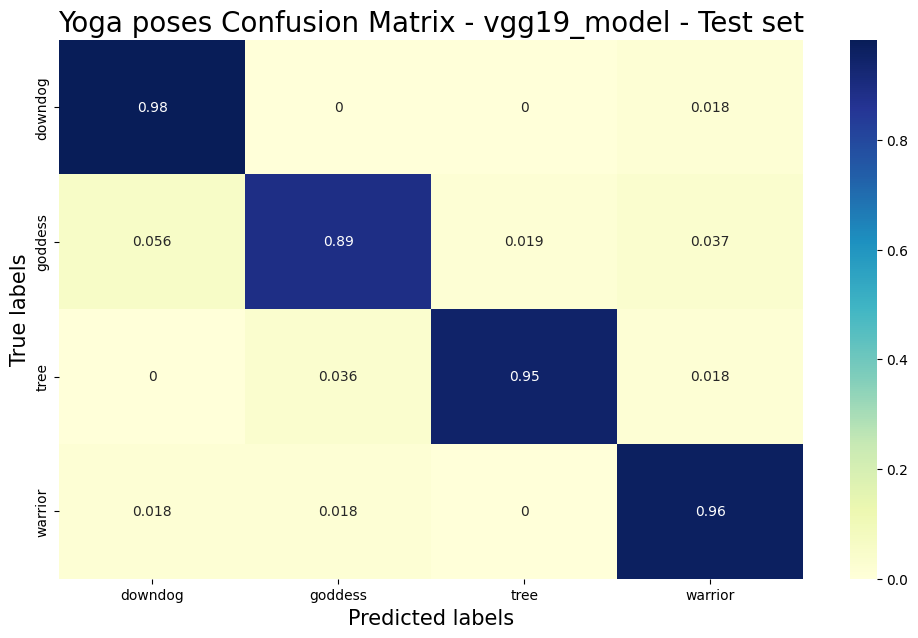

Accuracy Test set : 94.59%


In [33]:
cf_matrix = confusion_matrix(y_test_vgg19, y_test_hat_vgg19)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - vgg19_model - Test set', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy Test set : {accuracy_score(y_test_vgg19, y_test_hat_vgg19):.2%}')

### Inferencias en el set de train

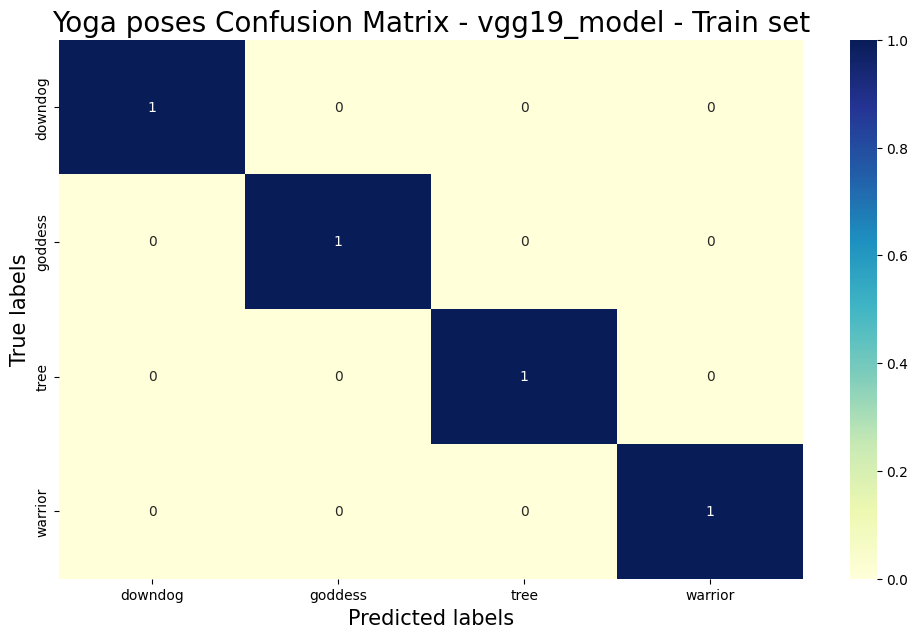

Accuracy Train set : 100.00%


In [ ]:
path = train_folder

y_train_vgg19 = []
y_train_hat_vgg19 = []
file_name = []

for class_name in os.listdir(path):
  for image in os.listdir(path + '/' + class_name):
    pred = np.argmax(
      vgg19_model(image_loader(data_transforms, path + '/' + class_name + '/' + image))
      .to('cpu').detach().numpy())

    y_train_vgg19.append(class_name)

    y_train_hat_vgg19.append(idx_to_name[pred])

    image_name = str(class_name) + str(image)

    file_name.append(image_name)

cf_matrix = confusion_matrix(y_train_vgg19, y_train_hat_vgg19)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - vgg19_model - Train set', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy Train set : {accuracy_score(y_train_vgg19, y_train_hat_vgg19):.2%}')

### Inferencias del dataset completo

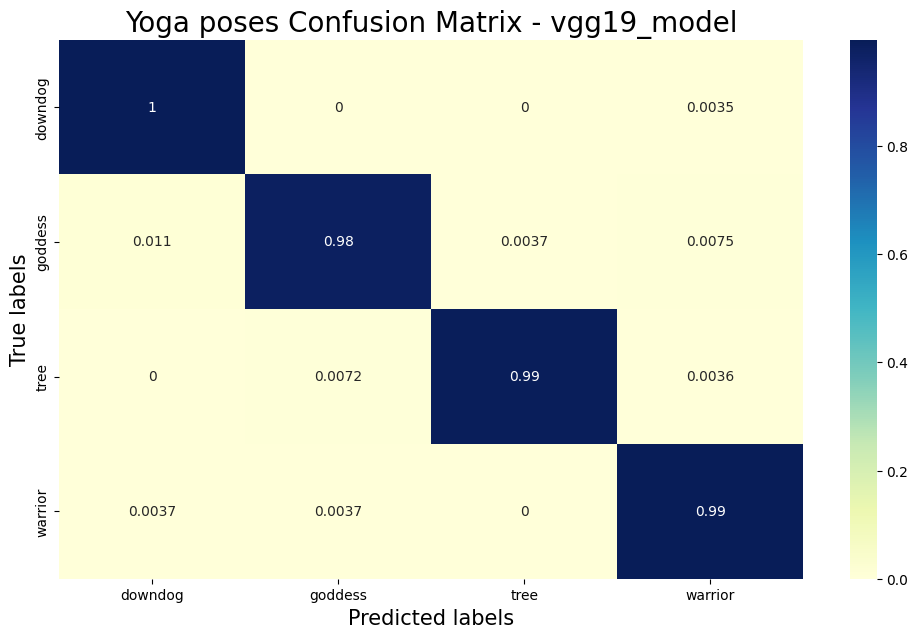

Accuracy all : 98.91%


In [ ]:
path = dataset_folder

y_vgg19 = []
y_hat_vgg19 = []
file_name = []

for folders in ['TRAIN', 'TEST']:
  for class_name in os.listdir(path + '/' + folders):
    for image in os.listdir(path + '/' + folders + '/' + class_name):
      pred = np.argmax(
        vgg19_model(
          image_loader(data_transforms, path + '/' + folders + '/' + class_name + '/' + image))
          .to('cpu').detach().numpy())

      y_vgg19.append(class_name)

      y_hat_vgg19.append(idx_to_name[pred])

      file_name.append(str(class_name) + str(image))

cf_matrix = confusion_matrix(y_vgg19, y_hat_vgg19)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - vgg19_model', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy all : {accuracy_score(y_vgg19, y_hat_vgg19):.2%}')

# Grad-cam

Analiza qué activaciones son más relevantes para la activación de la salida (o alguna neurona intermedia)
Dada las activaciones de interés A(k) se calcula la importancia de cada canal del mapa de características dado para la salida de interés, y luego se calcula la combinación lineal de todos los mapas y sus importancias.

Para realizar este análisis utilizo el codigo del siguiente repositorio: [`Git:Grad-cam`](https://github.com/jacobgil/pytorch-grad-cam.git)


In [35]:
# https://github.com/jacobgil/pytorch-grad-cam.git

import warnings
warnings.filterwarnings('ignore')
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


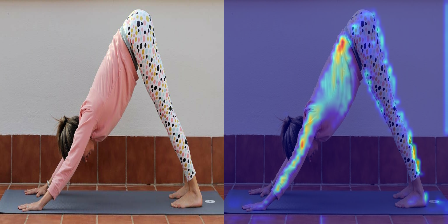

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


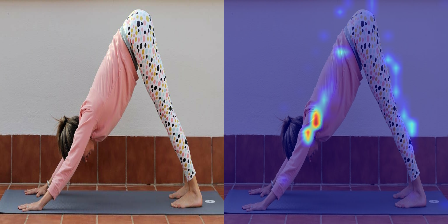

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


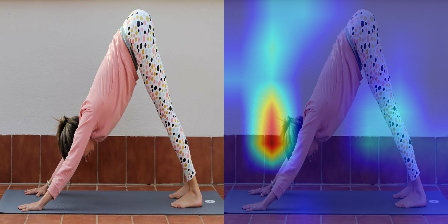

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


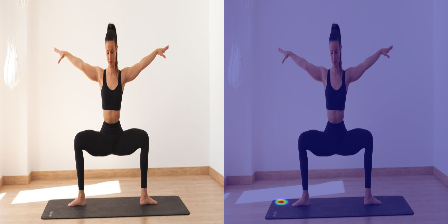

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


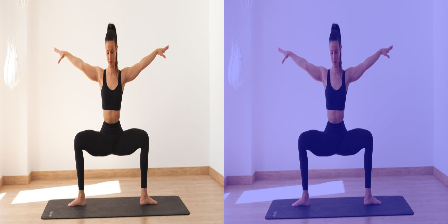

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


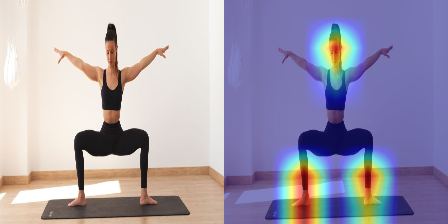

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


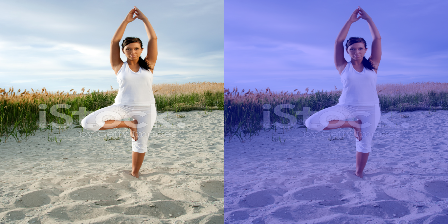

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


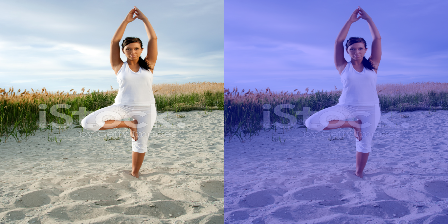

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


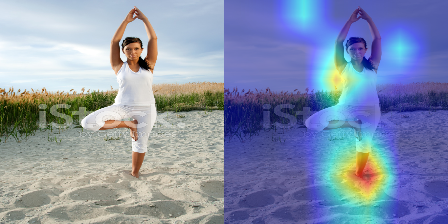

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


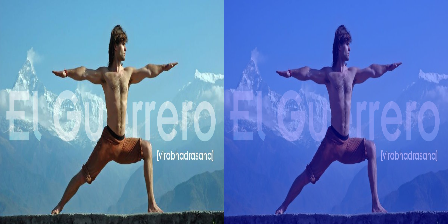

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


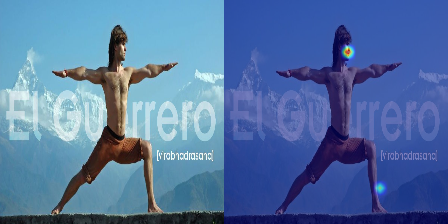

[MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)]


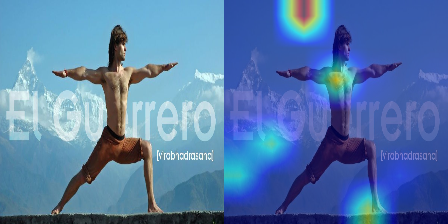

In [ ]:
model = vgg19_model
model.eval()
path = valid_folder

for image in os.listdir(path):

    image_url = 'DATASET/VALID/' + image
    img = np.array(Image.open(image_url))
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]).to(device)


    targets = [ClassifierOutputTarget(0)]
    target_layers = [[vgg19_model.features[9]],
                     [vgg19_model.features[18]],
                     [vgg19_model.features[36]]]
    for n, layers in enumerate(target_layers):
        with GradCAM(model=model, target_layers=layers) as cam:
            grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
            cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
        cam = np.uint8(255*grayscale_cams[0, :])
        # cam = cv2.merge([cam, cam, cam])
        # images = np.hstack((np.uint8(255*img), cam , cam_image))
        images = np.hstack((np.uint8(255*img), cam_image))

        print(layers)
        Image.fromarray(images).show()

## Realizamos la estimacion de posturas de video con VGG19

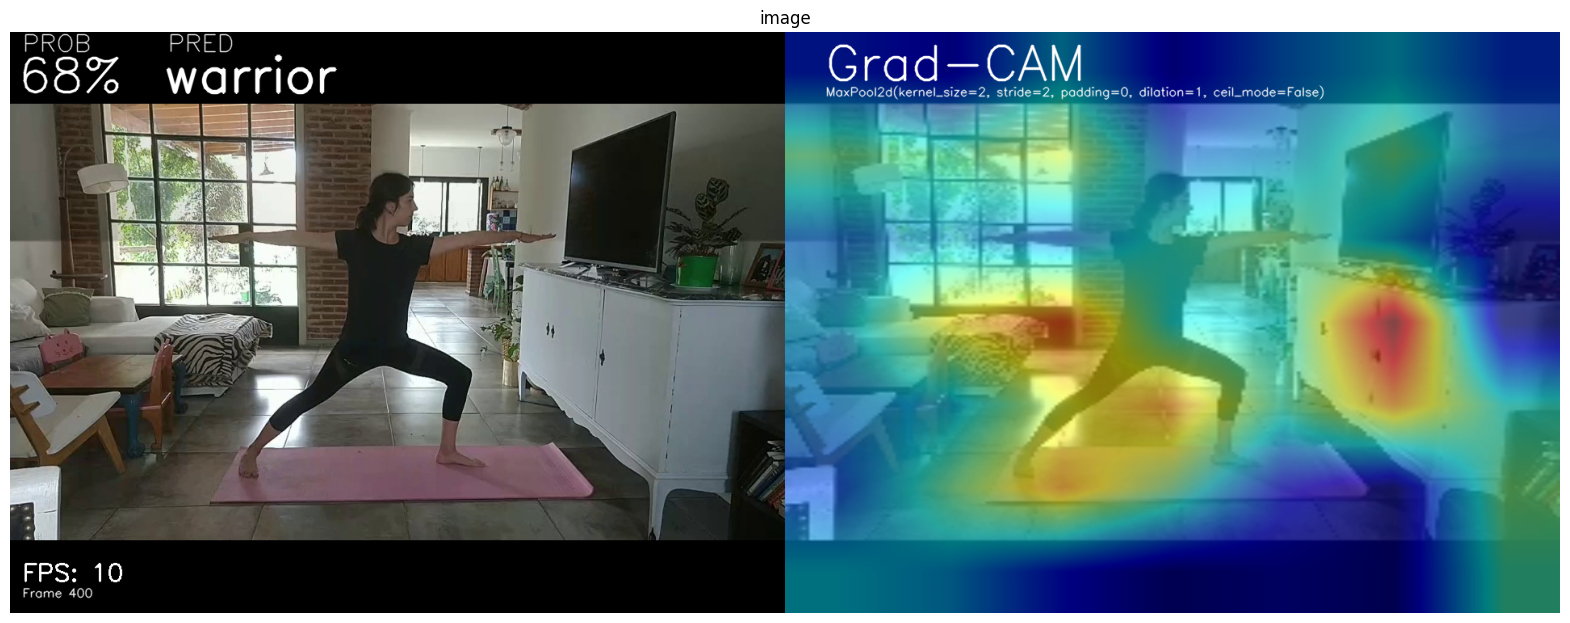

In [50]:
import time
cap = cv2.VideoCapture('sample_video.mp4')

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

result = cv2.VideoWriter('out_video_vgg19.mp4',
                             cv2.VideoWriter_fourcc(*"mp4v"),
                             20,
                             (width*2, height), True)

model = vgg19_model.eval()

def image_loader(loader, image):
    image = loader(image).float().to(device)
    image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(ANCHO_IMAGENES, ALTO_IMAGENES)),
    torchvision.transforms.ToTensor()])

start_time = time.time()
prev_frame_time = 0

while cap.isOpened():
    success, frame = cap.read()

    if not success:
        pass
    if frame is None:
        break

    # Predicción del Frame
    img = Image.fromarray(np.uint8(frame))
    output = model(image_loader(data_transforms,img))
    pred = idx_to_name[np.argmax((output).detach().to('cpu').numpy())]
    probabilities = torch.max(torch.nn.functional.softmax(output, dim=1).to(device)).item()
    image = frame

    # grad-CAM
    im = cv2.resize(image, (224, 224))
    im = np.float32(im) / 255
    input_tensor = preprocess_image(im, mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]).to(device)
    targets = [ClassifierOutputTarget(0)]
    target_layers = [vgg19_model.features[-1]]
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(im, grayscale_cams[0, :], use_rgb=False)
    cam_image=cv2.resize(cam_image, (width, height))

    # Mido FPS
    current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
    new_frame_time = time.time()
    fps = int(1/(new_frame_time-prev_frame_time))
    prev_frame_time = new_frame_time

    # Generar imagen final con agregado de la imformación
    image = np.concatenate((image, cam_image), axis=1)

    cv2.putText(image, 'PRED', (195, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                1, cv2.LINE_AA)
    cv2.putText(image, 'PROB', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                1, cv2.LINE_AA)
    cv2.putText(image, str(pred), (190, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                (255, 255, 255), 3, cv2.LINE_AA)
    cv2.putText(image, f'{probabilities:.0%}',(10, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(image, f'Grad-CAM', (1010, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255),
                2, cv2.LINE_AA)
    cv2.putText(image, f'{target_layers[0]}', (1010, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(image, f'Frame {current_frame}', (15, height-20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
    cv2.putText(image, f'FPS: {str(fps)}', (15, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                (250, 250, 250),2)

    # Guardar el video generado
    result.write(image)

    # Definir la imagen para imprimir
    print_frame = 400
    if current_frame == print_frame:
        print_image = image
    elif current_frame < print_frame:
        print_image = image

    cv2.imshow('Video', image)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
result.release()
cv2.destroyAllWindows()

plt.figure(figsize=[20,10])
plt.title('image'); plt.axis('off');plt.imshow(print_image[:,:,::-1]);plt.show()

# MediaPipe

In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 42.2 MB/s eta 0:00:00


In [2]:
import cv2
import mediapipe as mp
from glob import iglob
import csv
import pathlib

### Clase para generar los dataset de coordenadas de los puntos claves del modelo de MediaPipe desde las imagenes

In [ ]:
class GetCoordsLandmarksImages():

    '''class to obtain the coordinates of the landmarks form body images  using MediaPipe-Pose
    framework'''

    def __init__(self):

        self.file_list_used= []
        self.mp_pose = mp.solutions.pose # Mediapipe Solutions
        pass

    def create_csv_file(self, file_name: str):

        '''"file_name": The name of the csv file as it will be stored. ("file_name.csv").'''

        self.file_name = file_name + '.csv'

        landmarks = ['class', 'path']
        for val in range(0, 33):
            landmarks += ['x{}'.format(val), 'y{}'.format(val), 'z{}'.format(val), 'v{}'.format(val)]

        with open(file_name + '.csv', mode='w', newline='') as f:
            csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
            csv_writer.writerow(landmarks)


    def get_coord(self, rootdir: str, class_name = None, file_name = None):

        '''
        Create a dataset with the coord of the landmarks of the images or videos stored in "rootdir"

        "rootdir": Path of the folder where the images or videos are stored.

        "class_name" : str, default = None - If not given, will be the folder name where the images
        or video are stored.

        "file_name" : str, default = None - If not given, the file created in "create_csv_file()"
        will be used.

        "min_detection_confidence" : mp_pose min_detection_confidence (default = 0.6).

        "min_tracking_confidence": mp_pose min_detection_confidence (default = 0.6).

        '''

        self.rootdir_glob = rootdir

        if file_name == None:
            file_name = self.file_name

        path_files_list = [f for f in iglob(rootdir, recursive=True) if os.path.isfile(f)]

        for path in path_files_list:

            image = cv2.imread(path)

            if class_name == None:
                class_name = pathlib.PurePath(os.path.normpath(path))
                class_name = class_name.parent.name


            with self.mp_pose.Pose(static_image_mode=True,
                                    min_detection_confidence=0.5,
                                    model_complexity=2) as pose:

                try:
                    # Recolor Feed
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image.flags.writeable = False

                    # Make Detections
                    results = pose.process(image)

                    # Recolor image back to BGR for rendering
                    image.flags.writeable = True
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                # Export coordinates

                    # Extract Pose landmarks
                    poses = results.pose_landmarks.landmark
                    pose_row = list(np.array(
                        [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                         for landmark in poses]).flatten())

                    # Append class name
                    pose_row.insert(0, class_name)
                    pose_row.insert(1, path)
                    self.file_list_used.append(path)

                    # Export to CSV
                    with open(file_name, mode='a', newline='') as f:
                        csv_writer = csv.writer(f, delimiter=',', quotechar='"',
                                                quoting=csv.QUOTE_MINIMAL)
                        csv_writer.writerow(pose_row)

                except:
                    pass

    def bad_images(self):

        '''Return the images that are bad for detection'''

        path_files_list = [f for f in iglob(self.rootdir_glob, recursive=True)
                           if os.path.isfile(f)]


        images_not_used=[]
        for j in path_files_list:
            if j not in self.file_list_used:
                images_not_used.append(j)

        print(f'{len(images_not_used)} bad images of {len(path_files_list)}')

        if len(images_not_used) > 0:
            print(images_not_used)

### Generación de cada Dataset

In [ ]:
get_data = GetCoordsLandmarksImages()
get_data.create_csv_file('mediapipe/df_downdog_train')
get_data.get_coord(train_folder + '/downdog/*', class_name='downdog')
get_data.bad_images()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


0 bad images of 228


In [ ]:
get_data.create_csv_file('mediapipe/df_downdog_test')
get_data.get_coord(test_folder +'/downdog/*', class_name='downdog')
get_data.bad_images()

1 bad images of 57
['DATASET/TEST/downdog/00252.jpg']


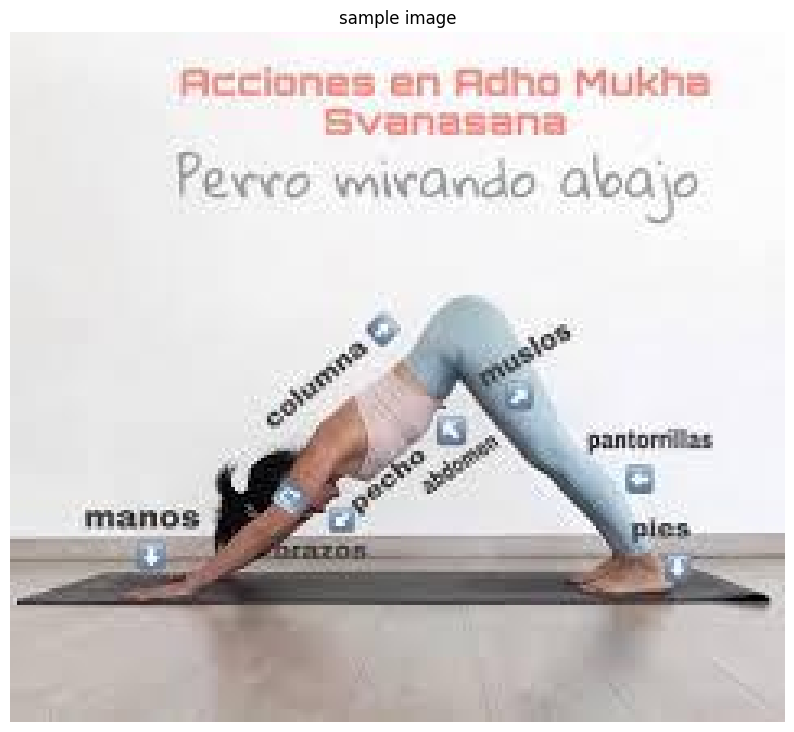

In [ ]:
# Imagen no usada
sample_img = cv2.imread('DATASET/TEST/downdog/00252.jpg')
plt.figure(figsize=[10,10])
plt.title('sample image'); plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

In [ ]:
get_data.create_csv_file('mediapipe/df_goddess_train')
get_data.get_coord(train_folder +'/goddess/*', class_name='goddess')
get_data.bad_images()

0 bad images of 213


In [ ]:
get_data.create_csv_file('mediapipe/df_goddess_test')
get_data.get_coord(test_folder +'/goddess/*', class_name='goddess')
get_data.bad_images()

0 bad images of 54


In [ ]:
get_data.create_csv_file('mediapipe/df_tree_train')
get_data.get_coord(train_folder +'/tree/*', class_name='tree')
get_data.bad_images()

0 bad images of 222


In [ ]:
get_data.create_csv_file('mediapipe/df_tree_test')
get_data.get_coord(test_folder +'/tree/*', class_name='tree')
get_data.bad_images()

0 bad images of 56


In [ ]:
get_data.create_csv_file('mediapipe/df_warrior_train')
get_data.get_coord(train_folder +'/warrior/*', class_name='warrior')
get_data.bad_images()

0 bad images of 217


In [ ]:
get_data.create_csv_file('mediapipe/df_warrior_test')
get_data.get_coord(test_folder +'/warrior/*', class_name='warrior')
get_data.bad_images()

0 bad images of 55


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn import svm

### Carga de los datasets generados

In [3]:
df_downdog_train = pd.read_csv("mediapipe/df_downdog_train.csv")
df_downdog_test = pd.read_csv("mediapipe/df_downdog_test.csv")
df_goddess_train = pd.read_csv("mediapipe/df_goddess_train.csv")
df_goddess_test = pd.read_csv("mediapipe/df_goddess_test.csv")
df_tree_train = pd.read_csv("mediapipe/df_tree_train.csv")
df_tree_test = pd.read_csv("mediapipe/df_tree_test.csv")
df_warrior_train = pd.read_csv("mediapipe/df_warrior_train.csv")
df_warrior_test = pd.read_csv("mediapipe/df_warrior_test.csv")

Armado el dataset de entrenamiento

In [4]:
df_yoga_train = pd.concat([df_downdog_train, df_goddess_train,df_tree_train,df_warrior_train],
                          ignore_index=True)
df_yoga_train

class                             path        x0        y0        z0  \
0    downdog  DATASET/TRAIN/downdog/00000.jpg  0.515906  0.744114 -0.097536   
1    downdog  DATASET/TRAIN/downdog/00001.jpg  0.563065  0.777623 -0.090526   
2    downdog  DATASET/TRAIN/downdog/00002.jpg  0.600316  0.741568 -0.035030   
3    downdog  DATASET/TRAIN/downdog/00003.jpg  0.543710  0.756082 -0.103799   
4    downdog  DATASET/TRAIN/downdog/00004.jpg  0.362943  0.697656 -0.121040   
..       ...                              ...       ...       ...       ...   
875  warrior  DATASET/TRAIN/warrior/00212.jpg  0.496748  0.380531 -0.191541   
876  warrior  DATASET/TRAIN/warrior/00213.jpg  0.594334  0.394090 -0.136816   
877  warrior  DATASET/TRAIN/warrior/00214.jpg  0.447354  0.223587 -0.364347   
878  warrior  DATASET/TRAIN/warrior/00215.jpg  0.516599  0.183675 -0.241107   
879  warrior  DATASET/TRAIN/warrior/00216.jpg  0.482414  0.197047 -0.159991   

           v0        x1        y1        z1        v1  ...       z30  \
0    0.996522  0.494697  0.768830 -0.145821  0.993423  ...  0.498111   
1    0.996063  0.581172  0.787468 -0.075686  0.983017  ... -0.094023   
2    0.996072  0.627442  0.749637 -0.009316  0.981456  ... -0.087180   
3    0.994289  0.562595  0.776741 -0.083682  0.981943  ... -0.009829   
4    0.997164  0.338230  0.717659 -0.174528  0.995215  ...  0.465399   
..        ...       ...       ...       ...       ...  ...       ...   
875  0.999996  0.502367  0.366985 -0.193306  0.999979  ... -0.015326   
876  0.999999  0.586266  0.380774 -0.109052  0.999997  ... -0.035777   
877  0.999999  0.458020  0.205496 -0.337254  0.999996  ... -0.009470   
878  1.000000  0.524648  0.167869 -0.221828  1.000000  ... -0.336754   
879  0.999993  0.490923  0.180772 -0.159587  0.999947  ...  0.029944   

          v30       x31       y31       z31       v31       x32       y32  \
0    0.027243  0.788467  0.929714 -0.156101  0.446178  0.783154  0.904320   
1    0.850045  0.249485  0.891746  0.085894  0.106207  0.243897  0.899256   
2    0.953919  0.207605  0.882052  0.257401  0.191142  0.198678  0.900976   
3    0.539648  0.278560  0.874888  0.248328  0.034623  0.271963  0.879571   
4    0.020710  0.740083  0.901112 -0.254253  0.441630  0.729549  0.886826   
..        ...       ...       ...       ...       ...       ...       ...   
875  0.970082  0.654213  0.832121 -0.353215  0.995961  0.389071  0.824434   
876  0.989647  0.780129  0.969453 -0.022373  0.999200  0.263608  0.983982   
877  0.861383  0.720666  0.934440 -0.345780  0.948181  0.154201  0.895073   
878  0.999934  0.707560  0.924740  0.539333  0.999941  0.323543  0.984423   
879  0.965719  0.719240  0.965417 -0.163414  0.990783  0.309747  0.928183   

          z32       v32  
0    0.387491  0.017338  
1   -0.223244  0.758937  
2   -0.262215  0.931412  
3   -0.182452  0.455704  
4    0.332924  0.011379  
..        ...       ...  
875 -0.098068  0.986727  
876 -0.202788  0.998024  
877 -0.132832  0.905913  
878 -0.447932  0.999991  
879 -0.045561  0.979865  

[880 rows x 134 columns]

Armado el dataset de test

In [5]:
df_yoga_test = pd.concat([df_downdog_test, df_goddess_test,df_tree_test,df_warrior_test],
                         ignore_index=True)
df_yoga_test

class                            path        x0        y0        z0  \
0    downdog  DATASET/TEST/downdog/00228.jpg  0.595601  0.732574  0.010670   
1    downdog  DATASET/TEST/downdog/00229.jpg  0.573218  0.772710 -0.041217   
2    downdog  DATASET/TEST/downdog/00230.jpg  0.331090  0.772926 -0.098299   
3    downdog  DATASET/TEST/downdog/00231.jpg  0.538576  0.655824 -0.020897   
4    downdog  DATASET/TEST/downdog/00232.jpg  0.528392  0.750586  0.025507   
..       ...                             ...       ...       ...       ...   
216  warrior  DATASET/TEST/warrior/00267.jpg  0.483201  0.203150 -0.154624   
217  warrior  DATASET/TEST/warrior/00268.jpg  0.433411  0.204863 -0.353004   
218  warrior  DATASET/TEST/warrior/00269.jpg  0.417122  0.311815 -0.112757   
219  warrior  DATASET/TEST/warrior/00270.jpg  0.544335  0.252073 -0.299133   
220  warrior  DATASET/TEST/warrior/00271.jpg  0.464598  0.123747 -0.137762   

           v0        x1        y1        z1        v1  ...       z30  \
0    0.996769  0.616857  0.736462  0.019970  0.984666  ...  0.022726   
1    0.998908  0.593480  0.784839 -0.028791  0.995231  ... -0.126812   
2    0.997200  0.307627  0.769864 -0.147185  0.995961  ...  0.419996   
3    0.995509  0.550316  0.665630 -0.011623  0.984367  ... -0.066557   
4    0.991797  0.546811  0.764924  0.030065  0.971236  ... -0.079024   
..        ...       ...       ...       ...       ...  ...       ...   
216  0.999992  0.490715  0.184958 -0.153046  0.999932  ...  0.005713   
217  0.999952  0.444026  0.185251 -0.352727  0.999775  ... -0.036858   
218  0.999991  0.423260  0.297623 -0.115043  0.999948  ...  0.078737   
219  0.999999  0.537099  0.236789 -0.280086  0.999992  ...  0.074931   
220  0.999979  0.475591  0.103290 -0.139308  0.999891  ... -0.015635   

          v30       x31       y31       z31       v31       x32       y32  \
0    0.982553  0.320085  0.877216  0.178809  0.432403  0.316787  0.899868   
1    0.992465  0.295866  0.860701  0.029760  0.429829  0.291235  0.869581   
2    0.034612  0.758326  0.902049 -0.242536  0.395012  0.756553  0.893923   
3    0.932512  0.375906  0.807251  0.061639  0.185773  0.370490  0.823114   
4    0.972385  0.228723  0.892275  0.101174  0.183241  0.211202  0.907751   
..        ...       ...       ...       ...       ...       ...       ...   
216  0.960438  0.716718  0.963977 -0.139607  0.989779  0.317514  0.929922   
217  0.962329  0.822961  0.789975 -0.127102  0.975794  0.184040  0.778373   
218  0.973068  0.647251  0.940722 -0.203804  0.995898  0.278991  0.885786   
219  0.922504  0.702731  0.889821  0.013040  0.994385  0.298285  0.908441   
220  0.940828  0.755722  0.947425 -0.177047  0.972065  0.232979  0.891648   

          z32       v32  
0   -0.064911  0.975885  
1   -0.237820  0.990049  
2    0.276947  0.017023  
3   -0.157325  0.903055  
4   -0.158930  0.949332  
..        ...       ...  
216 -0.079099  0.981990  
217 -0.187981  0.983038  
218  0.019305  0.980970  
219 -0.058212  0.986226  
220 -0.128311  0.956594  

[221 rows x 134 columns]

División de los datsets

In [6]:
X_train = df_yoga_train.drop(columns=['class', 'path'])
y_train = df_yoga_train['class']
X_test = df_yoga_test.drop(columns=['class', 'path'])
y_test = df_yoga_test['class']

In [7]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

test_slip = int((X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)
train_slip = int((X_train.shape[0]/(X_train.shape[0]+X_test.shape[0]))*100)


print(f'Split Train/Test: {int(train_slip)}%-{int(test_slip)}%')

X_train shape:  (880, 132)
X_test shape:  (221, 132)
y_train shape:  (880,)
y_test shape:  (221,)
Split Train/Test: 79%-20%


### Verificación del balance de clases

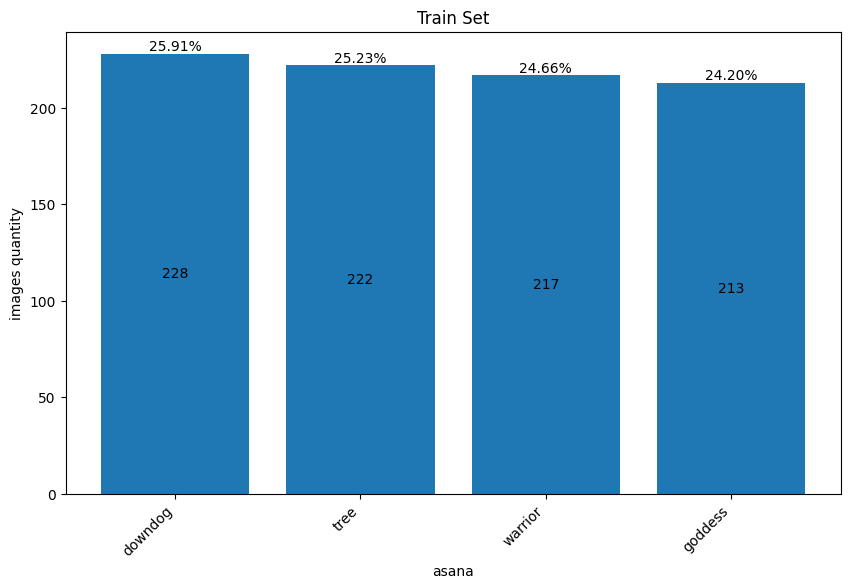

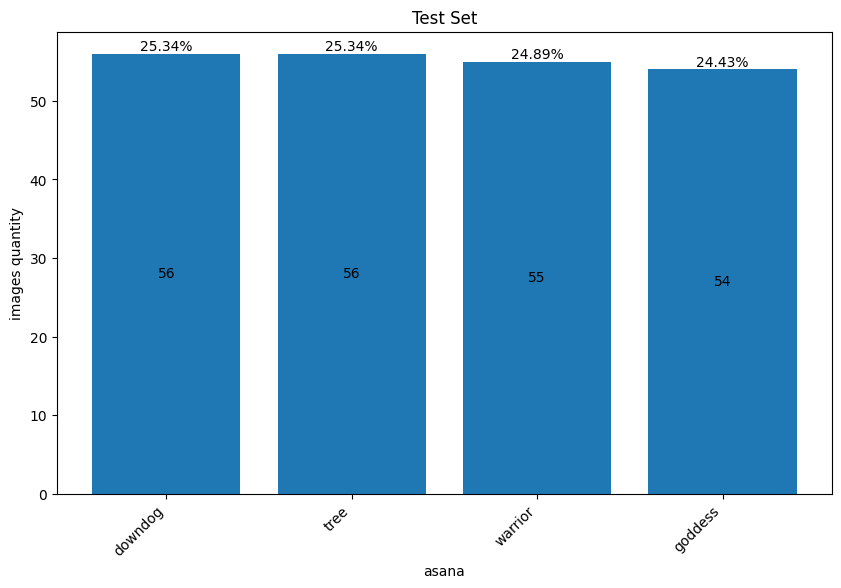

In [8]:
# Calcular counts y porcentajes
for i, set in zip((y_train, y_test), ('Train Set', 'Test Set')):
    valid_categories = i
    category_counts = valid_categories.value_counts()
    total_count = len(valid_categories)
    category_percentages = (category_counts / total_count) * 100

    # Grafico
    plt.figure(figsize=(10, 6))
    bars = plt.bar(category_counts.index, category_counts)
    plt.xlabel("asana")
    plt.ylabel("images quantity")
    plt.bar_label(bars, label_type='center')

    # Agregar porcentajes sobre las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        category = category_counts.index[i]
        if category in category_percentages:
            percentage = category_percentages[category]
            plt.text(bar.get_x() + bar.get_width() / 2,
                     height,
                     f"{percentage:.2f}%",
                     ha="center",
                     va="bottom")

    plt.xticks(rotation=45, ha="right")
    plt.title(str(set))
    plt.show()

## Entrenamiento de los modelos

In [11]:
# Definicion de los modelos a entrenar
pipelines = {
    'lr':make_pipeline(LogisticRegression(max_iter = 2000)),
    'lrcv': make_pipeline(LogisticRegressionCV(max_iter = 2000)),
    'rf':make_pipeline(RandomForestClassifier()),
    'svm':make_pipeline(svm.SVC()),
    'AdaBC':make_pipeline(AdaBoostClassifier()),
    'bagg':make_pipeline(BaggingClassifier()),
}

# Entrenamiento de los modelos
fit_models = {}
for algo, pipeline in pipelines.items():
    model = pipeline.fit(X_train, y_train)
    fit_models[algo] = model

# Evaluación de los modelos
for algo, model in fit_models.items():
    yhat = model.predict(X_test)
    print(f'Accuracy {algo}: {accuracy_score(y_test, yhat):.5%}')

Accuracy lr: 99.54751%
Accuracy lrcv: 99.54751%
Accuracy rf: 99.09502%
Accuracy svm: 99.09502%
Accuracy AdaBC: 46.15385%
Accuracy bagg: 97.28507%


In [ ]:
# # Guardado del modelo
# import pickle
# with open('models/mediapipe_model_yoga.pkl', 'wb') as f:
#     pickle.dump(fit_models['lrcv'], f)

In [ ]:
# Cargar modelo guardado
with open('models/mediapipe_model_yoga.pkl', 'rb') as f:
    model = pickle.load(f)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


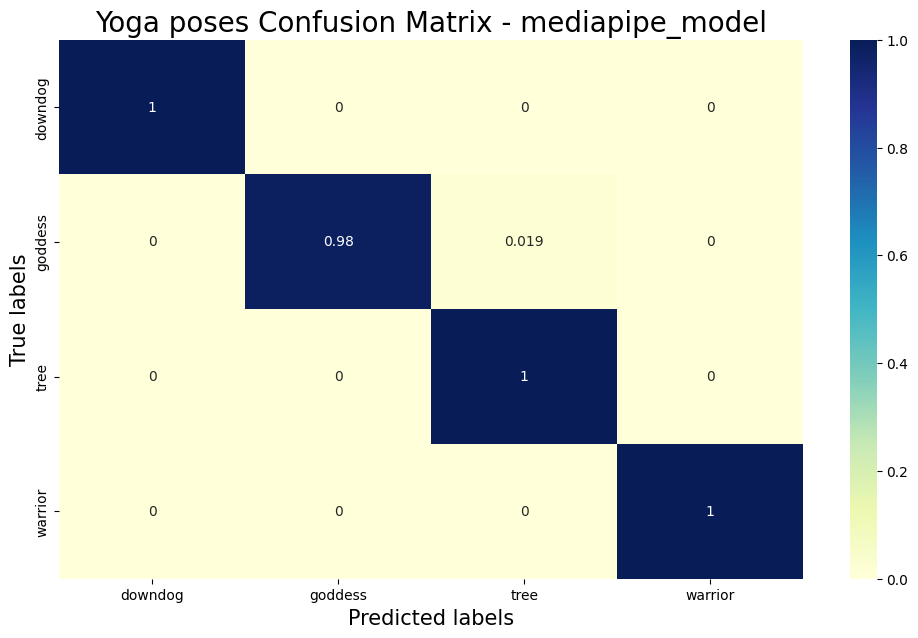

Accuracy Mediapipe : 99.55%


In [ ]:
mp_pose = mp.solutions.pose # Mediapipe Solutions

model = fit_models['lrcv']

landmarks = []
for val in range(0, 33):
            landmarks += ['x{}'.format(val),
                          'y{}'.format(val),
                          'z{}'.format(val),
                          'v{}'.format(val)]

y_mediapipe = []
y_hat_mediapipe = []
file_name = []

path = test_folder
for class_name in os.listdir(path):
    for image in os.listdir(path + '/' +  class_name):

        image_path = path + '/' + class_name + '/' + image

        image = cv2.imread(image_path)

        with mp_pose.Pose(static_image_mode=True,
                          min_detection_confidence=0.5,
                          model_complexity=2) as pose:

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image.flags.writeable = False

            # Make Detections
            results = pose.process(image)

            #Recolor image back to BGR for rendering
            image.flags.writeable = True
            image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

            poses = results.pose_landmarks.landmark
            pose_row = list(np.array(
                [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                for landmark in poses]).flatten())

            X = pd.DataFrame([pose_row], columns=landmarks)
            body_language_class = model.predict(X)[0]

        y_mediapipe.append(class_name)
        y_hat_mediapipe.append(body_language_class)
        file_name.append(image_path)

cf_matrix = confusion_matrix(y_mediapipe, y_hat_mediapipe)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in list(df_yoga_train['class'].unique())],
                     columns = [i for i in list(df_yoga_train['class'].unique())])

plt.figure(figsize = (12,7))
ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.title('Yoga poses Confusion Matrix - mediapipe_model', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)
plt.show()

print(f'Accuracy Mediapipe : {accuracy_score(y_mediapipe, y_hat_mediapipe):.2%}')

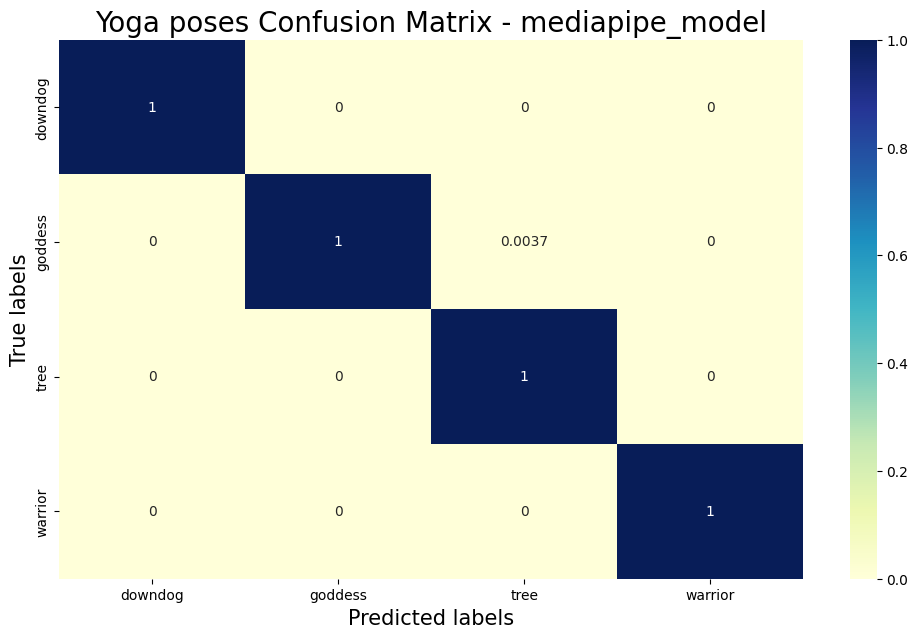

Accuracy Mediapipe : 99.91%


In [ ]:
mp_pose = mp.solutions.pose # Mediapipe Solutions

model = fit_models['lrcv']

landmarks = []
for val in range(0, 33):
            landmarks += ['x{}'.format(val),
                          'y{}'.format(val),
                          'z{}'.format(val),
                          'v{}'.format(val)]

y_mediapipe = []
y_hat_mediapipe = []
file_name = []

path = dataset_folder
for folders in ['TRAIN', 'TEST']:
  for class_name in os.listdir(path + '/' + folders):
    for image in os.listdir(path + '/' + folders + '/' + class_name):

      image_path = path + '/' + folders + '/' + class_name + '/' + image

      image = cv2.imread(image_path)

      with mp_pose.Pose(static_image_mode=True,
                        min_detection_confidence=0.5,
                        model_complexity=2) as pose:

          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image.flags.writeable = False

          # Make Detections
          results = pose.process(image)

          #Recolor image back to BGR for rendering
          image.flags.writeable = True
          image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

          poses = results.pose_landmarks.landmark
          pose_row = list(np.array(
              [[landmark.x, landmark.y, landmark.z, landmark.visibility]
              for landmark in poses]).flatten())

          X = pd.DataFrame([pose_row], columns=landmarks)
          body_language_class = model.predict(X)[0]

      y_mediapipe.append(class_name)
      y_hat_mediapipe.append(body_language_class)
      file_name.append(image_path)

cf_matrix = confusion_matrix(y_mediapipe, y_hat_mediapipe)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in list(df_yoga_train['class'].unique())],
                     columns = [i for i in list(df_yoga_train['class'].unique())])

plt.figure(figsize = (12,7))
ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")
plt.title('Yoga poses Confusion Matrix - mediapipe_model', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)
plt.show()

print(f'Accuracy Mediapipe : {accuracy_score(y_mediapipe, y_hat_mediapipe):.2%}')



In [ ]:
data = pd.DataFrame(list(zip(file_name, y_mediapipe, y_hat_mediapipe)),
                    columns = ['file_name', 'class', 'y_hat_mediapipe'])
data

file_name    class y_hat_mediapipe
0     DATASET/TRAIN/downdog/00000.jpg  downdog         downdog
1     DATASET/TRAIN/downdog/00001.jpg  downdog         downdog
2     DATASET/TRAIN/downdog/00002.jpg  downdog         downdog
3     DATASET/TRAIN/downdog/00003.jpg  downdog         downdog
4     DATASET/TRAIN/downdog/00004.jpg  downdog         downdog
...                               ...      ...             ...
1097   DATASET/TEST/warrior/00267.jpg  warrior         warrior
1098   DATASET/TEST/warrior/00268.jpg  warrior         warrior
1099   DATASET/TEST/warrior/00269.jpg  warrior         warrior
1100   DATASET/TEST/warrior/00270.jpg  warrior         warrior
1101   DATASET/TEST/warrior/00271.jpg  warrior         warrior

[1102 rows x 3 columns]

958


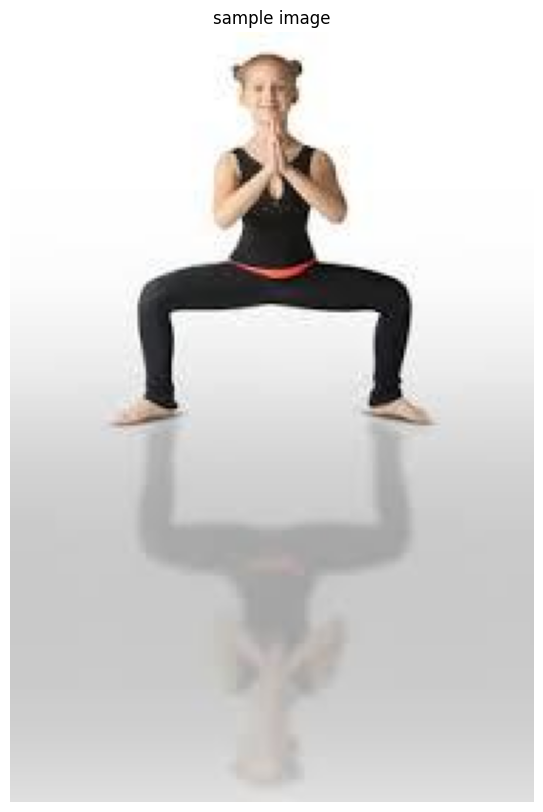

In [ ]:
# Vizualizamos la imagen que el modelo detecto mal
n=-1
for i, j in zip(data['class'], data['y_hat_mediapipe']):
  n += 1
  if i != j:
    det_wrong = n
    print(n)
sample_img = cv2.imread(data['file_name'][det_wrong])
plt.figure(figsize=[10,10])
plt.title('sample image'); plt.axis('off');plt.imshow(sample_img[:,:,::-1]);plt.show()

## Realizamos la estimacion de posturas de video con MediaPipe

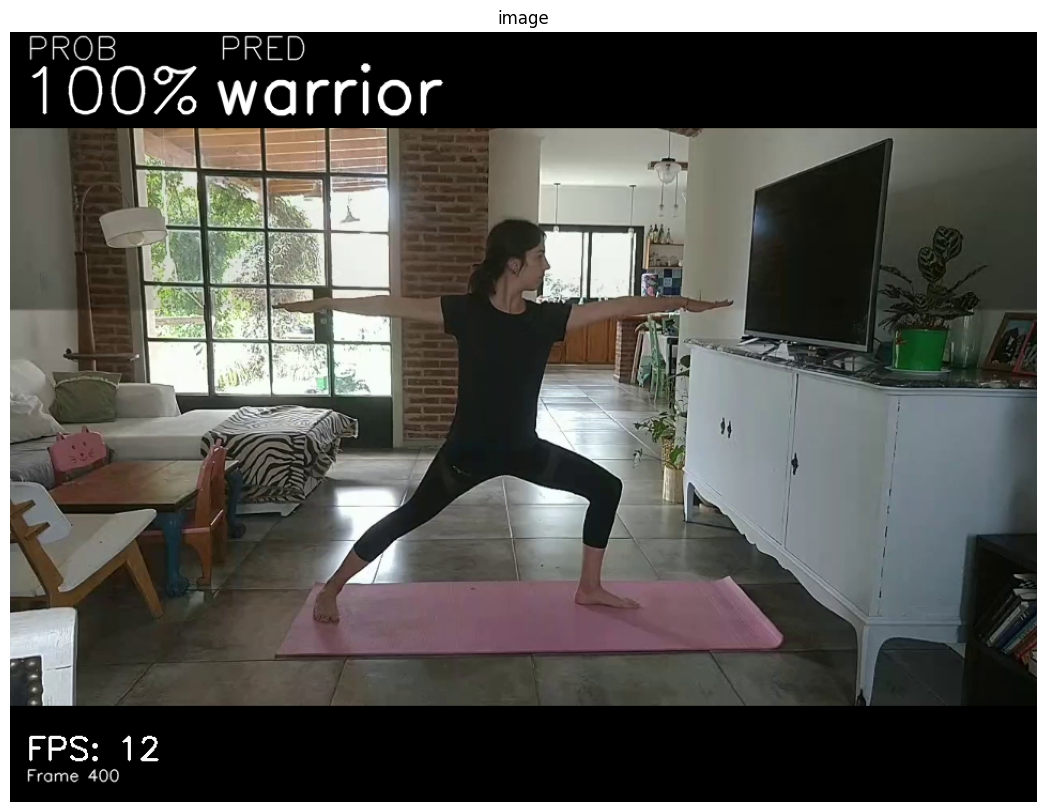

In [49]:
import time
cap = cv2.VideoCapture('sample_video.mp4')

width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

result = cv2.VideoWriter('out_video_mp.mp4',
                             cv2.VideoWriter_fourcc(*"mp4v"),
                             20,
                             (width, height), True)

mp_pose = mp.solutions.pose # Mediapipe Solutions

model = fit_models['lrcv']

landmarks = []
for val in range(0, 33):
            landmarks += ['x{}'.format(val),
                          'y{}'.format(val),
                          'z{}'.format(val),
                          'v{}'.format(val)]

start_time = time.time()
prev_frame_time = 0
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        success, frame = cap.read()

        if not success:
            pass
        if frame is None:
            break

        # Recolor Feed
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False

        # Make Detections
        results = pose.process(image)

        # Recolor image back to BGR for rendering
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)        
        
        # Predicción del Frame
        poses = results.pose_landmarks.landmark
        row = list(np.array(
            [[landmark.x, landmark.y, landmark.z, landmark.visibility]
                for landmark in poses]).flatten())
        X = pd.DataFrame([row], columns=landmarks)
        pred = model.predict(X)[0]
        probabilities = model.predict_proba(X)[0]

        # Mido FPS
        current_frame = int(cap.get(cv2.CAP_PROP_POS_FRAMES))
        new_frame_time = time.time()
        fps = int(1/(new_frame_time-prev_frame_time))
        prev_frame_time = new_frame_time

        # Generar imagen final con agregado de la imformación

        cv2.putText(image, 'PRED', (195, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                    1, cv2.LINE_AA)
        cv2.putText(image, 'PROB', (15, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),
                    1, cv2.LINE_AA)
        cv2.putText(image, str(pred), (190, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                    (255, 255, 255), 3, cv2.LINE_AA)
        cv2.putText(image, f'{probabilities[np.argmax(probabilities)]:.0%}',(10, 75), cv2.FONT_HERSHEY_SIMPLEX, 2,
                    (255, 255, 255), 2, cv2.LINE_AA)
        cv2.putText(image, f'Frame {current_frame}', (15, height-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image, f'FPS: {str(fps)}', (15, height-40), cv2.FONT_HERSHEY_SIMPLEX, 1,
                    (250, 250, 250),2)

        # Guardar el video generado
        result.write(image)

        # Definir la imagen para imprimir
        print_frame = 400
        if current_frame == print_frame:
            print_image = image
        elif current_frame < print_frame:
            print_image = image

        cv2.imshow('Video', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

cap.release()
result.release()
cv2.destroyAllWindows()

plt.figure(figsize=[20,10])
plt.title('image'); plt.axis('off');plt.imshow(print_image[:,:,::-1]);plt.show()

# Conclusión

#### Si bien con el modelo entrenado con la arquitectura VGG19 se logro un accuracy muy bueno en el set de testeo, se pudo ver que las predicciones realizadas en el video de ejemplo no fueron lo suficientemente buenas, con varios errores y posturas no detectadas. Por otro lado utilizando el framework de MediaPipe y un modelo de detección muy sencillo como es una regresión logística la detección en video fueron muy buenas logrando un accuracy del casi el 100%.